In [1]:
#lets create the synthetic data first 
#let me use the tensorflow contrib to get the mnist data 
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)


Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [2]:
#shapes of the various images
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.validation.images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(0, 28, 28, 1)


In [3]:
#shape of the labels as expected
print(mnist.train.labels.shape)

(60000, 10)


In [4]:
import numpy as np
import random
import time
import os
import _pickle as cPickle
import matplotlib.pyplot as plt
import scipy.misc
%matplotlib inline

In [5]:
def create_synthetic_dataset(images,labels):

    #We will extract 1-5 random indices and then join all the images together as well as labels 
    num_images = len(images)
    new_images = np.zeros((num_images,56,56))
    images = images.reshape((num_images,28,28))
    new_labels = []
    for i in range(num_images):
        num_digits = random.randint(1,5) #the number of digits can be from 1 to 5
        
        random_indices = [random.randint(0,num_images - 1) for _ in range(num_digits)]
        new_image = np.hstack(images[random_indices])
        new_label = list(labels[random_indices]) 
        
        for _ in range(0,5 - num_digits):
            new_image = np.hstack([new_image,np.zeros((28,28))])
            new_label.append(10) #this 10 is for blank class
        
        new_image = scipy.misc.imresize(new_image,size = (56,56))
        new_images[i] = new_image
        new_labels.append(tuple(new_label)) #here we have used tuple so that it is immutable
    
    return new_images,new_labels

In [6]:
start = time.time()
train_images,train_labels = create_synthetic_dataset(mnist.train.images,np.argmax(mnist.train.labels,axis = 1))
end = time.time()
print("time taken is",end - start,'seconds')

time taken is 16.268810749053955 seconds


In [7]:
start = time.time()
test_images,test_labels = create_synthetic_dataset(mnist.test.images,np.argmax(mnist.test.labels,axis = 1))
end = time.time()
print("time taken is",end - start,'seconds')

time taken is 2.281191110610962 seconds


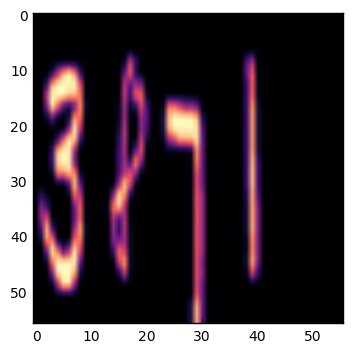

In [8]:
#looking at the data 
plt.imshow(train_images[0],cmap = 'magma' )

In [9]:
train_labels[0]

(3, 8, 7, 1, 10)

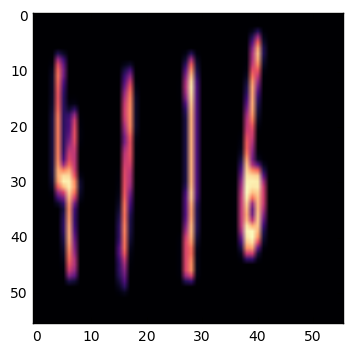

In [10]:
#looking at the data 
plt.imshow(test_images[0],cmap = 'magma' )

In [11]:
test_labels[0]

(4, 1, 1, 6, 10)

In [12]:
#make it viable for the algorithm
train_images = train_images.reshape((60000,56,56,1))

In [13]:
train_images.shape

(60000, 56, 56, 1)

In [14]:
#make it viable for the algorithm
test_images = test_images.reshape((10000,56,56,1))

In [15]:
test_images.shape

(10000, 56, 56, 1)

### Making the labels suitable too each digit has to be converted to OHE and labels shape should be (5,n,11)

In [16]:
def convert_labels(labels):
    #labels should be of size (5,n,11) here 11 is the number of classes possible including 11
    num_classes = 11
    num_digits = 5
    labels_ohe = np.zeros(shape=(num_digits,len(labels),num_classes))
    for i,label in enumerate(labels):
        for j in range(num_digits):
            labels_ohe[j,i,label[j]] = 1
    
    return labels_ohe        

In [17]:
train_labels_ohe = convert_labels(train_labels)

In [18]:
train_labels_ohe.shape

(5, 60000, 11)

In [19]:
test_labels_ohe = convert_labels(test_labels)
test_labels_ohe.shape

(5, 10000, 11)

In [20]:
train_labels_ohe[:,0,:]

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

### Here we have multiple output cases so will take all of them in consideration for loss

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [22]:
sess = tf.Session(config = config)

In [23]:
graph = tf.get_default_graph()
graph.get_operations() #there are no operations added to the tf graph

[]

In [ ]:
#now let us train a model

#https://goo.gl/c9zuey

K = 4
L = 8
M = 12

X = tf.placeholder(tf.float32,[None,56,56,1]) #we do not know at this time how many samples we will have

#k number of filters
W1 = tf.Variable(tf.truncated_normal([5,5,1,K],stddev= 0.1))
B1 = tf.Variable(tf.ones([K])/10)


#k channels in previous output and L number of filters
W2 = tf.Variable(tf.truncated_normal([5,5,K,L],stddev= 0.1))
B2 = tf.Variable(tf.ones([L])/10)


W3 = tf.Variable(tf.truncated_normal([5,5,L,M],stddev= 0.1))
B3 = tf.Variable(tf.ones([M])/10)

#fully connected layer after this
N = 200

W4 = tf.Variable(tf.truncated_normal([14*14*M,N],stddev=0.1))
B4 = tf.Variable(tf.ones([N])/10)

W_digit1 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit1 = tf.Variable(tf.ones([11])/10)

W_digit2 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit2 = tf.Variable(tf.ones([11])/10)

W_digit3 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit3 = tf.Variable(tf.ones([11])/10)

W_digit4 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit4 = tf.Variable(tf.ones([11])/10)

W_digit5 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit5 = tf.Variable(tf.ones([11])/10)

In [ ]:
len(graph.get_operations())

In [ ]:
#here X is (100,80,80,1) 100 is #of images
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding= 'SAME') +B1) #output is (100,56,56,4)

Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides = [1,2,2,1], padding= 'SAME') +B2) #output is (100,28,28,8)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides = [1,2,2,1], padding= 'SAME') +B3) #output is (100,14,14,12)

YY = tf.reshape(Y3, shape = [-1, 14 * 14 * M])  #essentially it will be (100,20*20*12)

Y4 = tf.nn.relu(tf.matmul(YY,W4) + B4)                 #(100,200)

In [ ]:
Y_logits1 = tf.matmul(Y4,W_digit1) + B_digit1
Y_logits2 = tf.matmul(Y4,W_digit2) + B_digit2
Y_logits3 = tf.matmul(Y4,W_digit3) + B_digit3
Y_logits4 = tf.matmul(Y4,W_digit4) + B_digit4
Y_logits5 = tf.matmul(Y4,W_digit5) + B_digit5

Y_digits1_ = tf.placeholder(tf.float32,[None,11])
Y_digits2_ = tf.placeholder(tf.float32,[None,11])
Y_digits3_ = tf.placeholder(tf.float32,[None,11])
Y_digits4_ = tf.placeholder(tf.float32,[None,11])
Y_digits5_ = tf.placeholder(tf.float32,[None,11])

correct1 = tf.equal(tf.argmax(Y_logits1,1),tf.argmax(Y_digits1_,1))
correct2 = tf.equal(tf.argmax(Y_logits2,1),tf.argmax(Y_digits2_,1))
correct3 = tf.equal(tf.argmax(Y_logits3,1),tf.argmax(Y_digits3_,1))
correct4 = tf.equal(tf.argmax(Y_logits4,1),tf.argmax(Y_digits4_,1))
correct5 = tf.equal(tf.argmax(Y_logits5,1),tf.argmax(Y_digits5_,1))

all_correct = tf.logical_and(tf.logical_and(tf.logical_and(tf.logical_and(
                    correct1,correct2),correct3),correct4),correct5)

num_correct1 = tf.reduce_sum(tf.cast(correct1,tf.float32)) 
num_correct2 = tf.reduce_sum(tf.cast(correct2,tf.float32)) 
num_correct3 = tf.reduce_sum(tf.cast(correct3,tf.float32))
num_correct4 = tf.reduce_sum(tf.cast(correct4,tf.float32)) 
num_correct5 = tf.reduce_sum(tf.cast(correct5,tf.float32)) 


global_correct = tf.reduce_sum(tf.cast(all_correct,tf.float32))

individual_correct = tf.add(tf.add(tf.add(tf.add(num_correct1,num_correct2),num_correct3)
                                   ,num_correct4),num_correct5)

cross_entropy1 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits1,labels = Y_digits1_)
cross_entropy1 = tf.reduce_sum(cross_entropy1) * 100 

cross_entropy2 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits2,labels = Y_digits2_)
cross_entropy2 = tf.reduce_sum(cross_entropy2) * 100 

cross_entropy3 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits3,labels = Y_digits3_)
cross_entropy3 = tf.reduce_sum(cross_entropy3) * 100 

cross_entropy4 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits4,labels = Y_digits4_)
cross_entropy4 = tf.reduce_sum(cross_entropy4) * 100 

cross_entropy5 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits5,labels = Y_digits5_)
cross_entropy5 = tf.reduce_sum(cross_entropy5) * 100 

cross_entropy = cross_entropy1 + cross_entropy2 + cross_entropy3 + cross_entropy4 + cross_entropy5 

In [ ]:
len(graph.get_operations())

### 2 Accuracies one individual one global

def calculate_accuracies(predicted_labels,real_labels):
    #both predicted labels and test labels will have dimension (5,n,11)
    num_digits,n,num_classes = predicted_labels.shape
    counter = 0
    global_counter = 0
    
    for i in range(n):   
        internal_counter = 0
        for j in range(num_digits):
            if real_labels[j,i] == predicted_labels[j,i]:
                counter += 1
                internal_counter += 1
        if internal_counter == 5:
            global_counter += 1
    
    global_accuracy = global_counter/n
    individual_accuracy = counter/(n * num_digits)
    
    return individual_accuracy,global_accuracy     

In [24]:
batch_index = 0

def next_batch(images,labels,batch_size):
    global batch_index
    if batch_index >= len(images) - batch_size - 1:
        batch_index = 0
    a = images[batch_index:batch_index + batch_size]
    b = labels[:,batch_index:batch_index + batch_size,:]
    batch_index += batch_size
    return a,b

In [ ]:
# With decaying learning rate


initial_learning_rate = 0.003
global_step = tf.Variable(0, trainable=False)

learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           5000, 0.96, staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step = global_step)

init = tf.global_variables_initializer()
sess.run(init)
b_size = 128
for i in range(4001):
    batch_X,batch_Y = next_batch(train_images,train_labels_ohe,batch_size=b_size)
    train_data = {X : batch_X, Y_digits1_: batch_Y[0],Y_digits2_ : batch_Y[1],
                  Y_digits3_: batch_Y[2],Y_digits4_:batch_Y[3],Y_digits5_:batch_Y[4]}
    
    #training the system
    sess.run(train_step , feed_dict = train_data)
    
    #success
    ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= train_data)
    
    if i % 500 == 0:
        print()
        #print(c)
        print("Iteration number %d Training accuracy individual %f global %f cross entropy loss %f"%(i,ind/(b_size*5),glob/b_size,c))
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        #success on test data
        
        test_data = {X : test_images,Y_digits1_ :test_labels_ohe[0],Y_digits2_:test_labels_ohe[1],
                    Y_digits3_:test_labels_ohe[2],Y_digits4_:test_labels_ohe[3],
                    Y_digits5_:test_labels_ohe[4]}
        
        ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= test_data)
        
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        print("Iteration number %d Testing accuracy individual %f global %f cross entropy loss %f"%(i,ind/(50000),glob/10000,c))

### Let us try another architecture

In [25]:
#now let us train a model

#https://goo.gl/c9zuey

K = 4
L = 12
M = 24

X = tf.placeholder(tf.float32,[None,56,56,1]) #we do not know at this time how many samples we will have

#k number of filters
W1 = tf.Variable(tf.truncated_normal([6,6,1,K],stddev= 0.1))
B1 = tf.Variable(tf.ones([K])/10)


#k channels in previous output and L number of filters
W2 = tf.Variable(tf.truncated_normal([5,5,K,L],stddev= 0.1))
B2 = tf.Variable(tf.ones([L])/10)


W3 = tf.Variable(tf.truncated_normal([5,5,L,M],stddev= 0.1))
B3 = tf.Variable(tf.ones([M])/10)

#fully connected layer after this
N = 200

W4 = tf.Variable(tf.truncated_normal([14*14*M,N],stddev=0.1))
B4 = tf.Variable(tf.ones([N])/10)

W_digit1 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit1 = tf.Variable(tf.ones([11])/10)

W_digit2 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit2 = tf.Variable(tf.ones([11])/10)

W_digit3 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit3 = tf.Variable(tf.ones([11])/10)

W_digit4 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit4 = tf.Variable(tf.ones([11])/10)

W_digit5 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit5 = tf.Variable(tf.ones([11])/10)

In [26]:
#here X is (100,80,80,1) 100 is #of images
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding= 'SAME') +B1) #output is (100,56,56,6)

Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides = [1,2,2,1], padding= 'SAME') +B2) #output is (100,28,28,12)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides = [1,2,2,1], padding= 'SAME') +B3) #output is (100,14,14,24)

YY = tf.reshape(Y3, shape = [-1, 14 * 14 * M])  #essentially it will be (100,20*20*12)

Y4 = tf.nn.relu(tf.matmul(YY,W4) + B4)                 #(100,200)

Y4 = tf.nn.dropout(Y4,keep_prob= 0.8)    #dropout introduced

In [27]:
Y_logits1 = tf.matmul(Y4,W_digit1) + B_digit1
Y_logits2 = tf.matmul(Y4,W_digit2) + B_digit2
Y_logits3 = tf.matmul(Y4,W_digit3) + B_digit3
Y_logits4 = tf.matmul(Y4,W_digit4) + B_digit4
Y_logits5 = tf.matmul(Y4,W_digit5) + B_digit5

Y_digits1_ = tf.placeholder(tf.float32,[None,11])
Y_digits2_ = tf.placeholder(tf.float32,[None,11])
Y_digits3_ = tf.placeholder(tf.float32,[None,11])
Y_digits4_ = tf.placeholder(tf.float32,[None,11])
Y_digits5_ = tf.placeholder(tf.float32,[None,11])

correct1 = tf.equal(tf.argmax(Y_logits1,1),tf.argmax(Y_digits1_,1))
correct2 = tf.equal(tf.argmax(Y_logits2,1),tf.argmax(Y_digits2_,1))
correct3 = tf.equal(tf.argmax(Y_logits3,1),tf.argmax(Y_digits3_,1))
correct4 = tf.equal(tf.argmax(Y_logits4,1),tf.argmax(Y_digits4_,1))
correct5 = tf.equal(tf.argmax(Y_logits5,1),tf.argmax(Y_digits5_,1))

all_correct = tf.logical_and(tf.logical_and(tf.logical_and(tf.logical_and(
                    correct1,correct2),correct3),correct4),correct5)

num_correct1 = tf.reduce_sum(tf.cast(correct1,tf.float32)) 
num_correct2 = tf.reduce_sum(tf.cast(correct2,tf.float32)) 
num_correct3 = tf.reduce_sum(tf.cast(correct3,tf.float32))
num_correct4 = tf.reduce_sum(tf.cast(correct4,tf.float32)) 
num_correct5 = tf.reduce_sum(tf.cast(correct5,tf.float32)) 


global_correct = tf.reduce_sum(tf.cast(all_correct,tf.float32))

individual_correct = tf.add(tf.add(tf.add(tf.add(num_correct1,num_correct2),num_correct3)
                                   ,num_correct4),num_correct5)

cross_entropy1 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits1,labels = Y_digits1_)
cross_entropy1 = tf.reduce_sum(cross_entropy1) * 100 

cross_entropy2 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits2,labels = Y_digits2_)
cross_entropy2 = tf.reduce_sum(cross_entropy2) * 100 

cross_entropy3 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits3,labels = Y_digits3_)
cross_entropy3 = tf.reduce_sum(cross_entropy3) * 100 

cross_entropy4 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits4,labels = Y_digits4_)
cross_entropy4 = tf.reduce_sum(cross_entropy4) * 100 

cross_entropy5 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits5,labels = Y_digits5_)
cross_entropy5 = tf.reduce_sum(cross_entropy5) * 100 

cross_entropy = cross_entropy1 + cross_entropy2 + cross_entropy3 + cross_entropy4 + cross_entropy5 

In [28]:
len(graph.get_operations())

407

In [29]:
# With decaying learning rate


initial_learning_rate = 0.003
global_step = tf.Variable(0, trainable=False)

learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           2000, 0.96, staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step = global_step)

init = tf.global_variables_initializer()
sess.run(init)
b_size = 128
for i in range(10001):
    batch_X,batch_Y = next_batch(train_images,train_labels_ohe,batch_size=b_size)
    train_data = {X : batch_X, Y_digits1_: batch_Y[0],Y_digits2_ : batch_Y[1],
                  Y_digits3_: batch_Y[2],Y_digits4_:batch_Y[3],Y_digits5_:batch_Y[4]}
    
    #training the system
    sess.run(train_step , feed_dict = train_data)
    
    #success
    ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= train_data)
    
    if i % 2000 == 0:
        print()
        #print(c)
        print("Iteration number %d Training accuracy individual %f global %f cross entropy loss %f"%(i,ind/(b_size*5),glob/b_size,c))
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        #success on test data
        
        test_data = {X : test_images,Y_digits1_ :test_labels_ohe[0],Y_digits2_:test_labels_ohe[1],
                    Y_digits3_:test_labels_ohe[2],Y_digits4_:test_labels_ohe[3],
                    Y_digits5_:test_labels_ohe[4]}
        
        ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= test_data)
        
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        print("Iteration number %d Testing accuracy individual %f global %f cross entropy loss %f"%(i,ind/(50000),glob/10000,c))


Iteration number 0 Training accuracy individual 0.348438 global 0.007812 cross entropy loss 4770126.000000
Iteration number 0 Testing accuracy individual 0.320000 global 0.000600 cross entropy loss 415484352.000000

Iteration number 2000 Training accuracy individual 0.965625 global 0.835938 cross entropy loss 6000.000488
Iteration number 2000 Testing accuracy individual 0.954500 global 0.799500 cross entropy loss 711174.125000

Iteration number 4000 Training accuracy individual 0.981250 global 0.906250 cross entropy loss 3802.676025
Iteration number 4000 Testing accuracy individual 0.962360 global 0.832600 cross entropy loss 672579.937500

Iteration number 6000 Training accuracy individual 0.979688 global 0.898438 cross entropy loss 3153.660889
Iteration number 6000 Testing accuracy individual 0.964460 global 0.840600 cross entropy loss 697228.625000

Iteration number 8000 Training accuracy individual 0.982812 global 0.914062 cross entropy loss 3127.542480
Iteration number 8000 Testin

### Another architecture this time lets increase a convolutional layer

In [54]:
#now let us train a model

#https://goo.gl/c9zuey

K = 4
L = 12
M = 24
O = 48

X = tf.placeholder(tf.float32,[None,56,56,1]) #we do not know at this time how many samples we will have

#k number of filters
W1 = tf.Variable(tf.truncated_normal([6,6,1,K],stddev= 0.1))
B1 = tf.Variable(tf.ones([K])/10)


#k channels in previous output and L number of filters
W2 = tf.Variable(tf.truncated_normal([5,5,K,L],stddev= 0.1))
B2 = tf.Variable(tf.ones([L])/10)


W3 = tf.Variable(tf.truncated_normal([5,5,L,M],stddev= 0.1))
B3 = tf.Variable(tf.ones([M])/10)

W4 = tf.Variable(tf.truncated_normal([5,5,M,O],stddev= 0.1))
B4 = tf.Variable(tf.ones([O])/10)
#fully connected layer after this
N = 200



W5 = tf.Variable(tf.truncated_normal([7*7*O,N],stddev=0.1))
B5 = tf.Variable(tf.ones([N])/10)

W_digit1 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit1 = tf.Variable(tf.ones([11])/10)

W_digit2 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit2 = tf.Variable(tf.ones([11])/10)

W_digit3 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit3 = tf.Variable(tf.ones([11])/10)

W_digit4 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit4 = tf.Variable(tf.ones([11])/10)

W_digit5 = tf.Variable(tf.truncated_normal([N,11],stddev= 0.1))
B_digit5 = tf.Variable(tf.ones([11])/10)

In [55]:
#here X is (100,80,80,1) 100 is #of images
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding= 'SAME') +B1) #output is (100,56,56,6)

Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides = [1,2,2,1], padding= 'SAME') +B2) #output is (100,28,28,12)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides = [1,2,2,1], padding= 'SAME') +B3) #output is (100,14,14,24)

Y4 = tf.nn.relu(tf.nn.conv2d(Y3, W4, strides = [1,2,2,1], padding = 'SAME') +B4) #output is (100,7,7,30)

YY = tf.reshape(Y4, shape = [-1, 7 * 7 * O])  #essentially it will be (100,7*7*30)

Y5 = tf.nn.relu(tf.matmul(YY,W5) + B5)                 #(100,200)

Y5 = tf.nn.dropout(Y5,keep_prob= 0.8)    #dropout introduced

In [56]:
Y_logits1 = tf.matmul(Y5,W_digit1) + B_digit1
Y_logits2 = tf.matmul(Y5,W_digit2) + B_digit2
Y_logits3 = tf.matmul(Y5,W_digit3) + B_digit3
Y_logits4 = tf.matmul(Y5,W_digit4) + B_digit4
Y_logits5 = tf.matmul(Y5,W_digit5) + B_digit5

Y_digits1_ = tf.placeholder(tf.float32,[None,11])
Y_digits2_ = tf.placeholder(tf.float32,[None,11])
Y_digits3_ = tf.placeholder(tf.float32,[None,11])
Y_digits4_ = tf.placeholder(tf.float32,[None,11])
Y_digits5_ = tf.placeholder(tf.float32,[None,11])

correct1 = tf.equal(tf.argmax(Y_logits1,1),tf.argmax(Y_digits1_,1))
correct2 = tf.equal(tf.argmax(Y_logits2,1),tf.argmax(Y_digits2_,1))
correct3 = tf.equal(tf.argmax(Y_logits3,1),tf.argmax(Y_digits3_,1))
correct4 = tf.equal(tf.argmax(Y_logits4,1),tf.argmax(Y_digits4_,1))
correct5 = tf.equal(tf.argmax(Y_logits5,1),tf.argmax(Y_digits5_,1))

all_correct = tf.logical_and(tf.logical_and(tf.logical_and(tf.logical_and(
                    correct1,correct2),correct3),correct4),correct5)

num_correct1 = tf.reduce_sum(tf.cast(correct1,tf.float32)) 
num_correct2 = tf.reduce_sum(tf.cast(correct2,tf.float32)) 
num_correct3 = tf.reduce_sum(tf.cast(correct3,tf.float32))
num_correct4 = tf.reduce_sum(tf.cast(correct4,tf.float32)) 
num_correct5 = tf.reduce_sum(tf.cast(correct5,tf.float32)) 


global_correct = tf.reduce_sum(tf.cast(all_correct,tf.float32))

individual_correct = tf.add(tf.add(tf.add(tf.add(num_correct1,num_correct2),num_correct3)
                                   ,num_correct4),num_correct5)

cross_entropy1 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits1,labels = Y_digits1_)
cross_entropy1 = tf.reduce_sum(cross_entropy1) * 100 

cross_entropy2 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits2,labels = Y_digits2_)
cross_entropy2 = tf.reduce_sum(cross_entropy2) * 100 

cross_entropy3 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits3,labels = Y_digits3_)
cross_entropy3 = tf.reduce_sum(cross_entropy3) * 100 

cross_entropy4 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits4,labels = Y_digits4_)
cross_entropy4 = tf.reduce_sum(cross_entropy4) * 100 

cross_entropy5 = tf.nn.softmax_cross_entropy_with_logits(logits = Y_logits5,labels = Y_digits5_)
cross_entropy5 = tf.reduce_sum(cross_entropy5) * 100 

cross_entropy = cross_entropy1 + cross_entropy2 + cross_entropy3 + cross_entropy4 + cross_entropy5 

In [57]:
len(graph.get_operations())

5017

In [59]:
# With decaying learning rate


initial_learning_rate = 0.003
global_step = tf.Variable(0, trainable=False)

learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           5000, 0.90, staircase=True)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step = global_step)

init = tf.global_variables_initializer()
sess.run(init)
b_size = 256
for i in range(20001):
    batch_X,batch_Y = next_batch(train_images,train_labels_ohe,batch_size=b_size)
    train_data = {X : batch_X, Y_digits1_: batch_Y[0],Y_digits2_ : batch_Y[1],
                  Y_digits3_: batch_Y[2],Y_digits4_:batch_Y[3],Y_digits5_:batch_Y[4]}
    
    #training the system
    sess.run(train_step , feed_dict = train_data)
    
    #success
    ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= train_data)
    
    if i % 4000 == 0:
        print()
        #print(c)
        print("Iteration number %d Training accuracy individual %f global %f cross entropy loss %f"%(i,ind/(b_size*5),glob/b_size,c))
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        #success on test data
        
        test_data = {X : test_images,Y_digits1_ :test_labels_ohe[0],Y_digits2_:test_labels_ohe[1],
                    Y_digits3_:test_labels_ohe[2],Y_digits4_:test_labels_ohe[3],
                    Y_digits5_:test_labels_ohe[4]}
        
        ind,glob,c = sess.run([individual_correct ,global_correct, cross_entropy],feed_dict= test_data)
        
        #print("Training iteration number",i,"accuracy",a,"loss",c)
        print("Iteration number %d Testing accuracy individual %f global %f cross entropy loss %f"%(i,ind/(50000),glob/10000,c))


Iteration number 0 Training accuracy individual 0.353906 global 0.000000 cross entropy loss 5268781.000000
Iteration number 0 Testing accuracy individual 0.308300 global 0.000900 cross entropy loss 243734784.000000

Iteration number 4000 Training accuracy individual 0.983594 global 0.917969 cross entropy loss 6167.850586
Iteration number 4000 Testing accuracy individual 0.968040 global 0.854500 cross entropy loss 554226.937500

Iteration number 8000 Training accuracy individual 0.988281 global 0.945312 cross entropy loss 4102.247070
Iteration number 8000 Testing accuracy individual 0.969540 global 0.859800 cross entropy loss 622988.625000

Iteration number 12000 Training accuracy individual 0.993750 global 0.972656 cross entropy loss 2260.747559
Iteration number 12000 Testing accuracy individual 0.973440 global 0.875400 cross entropy loss 663967.125000

Iteration number 16000 Training accuracy individual 0.993750 global 0.968750 cross entropy loss 2693.187988
Iteration number 16000 Te

In [64]:
from scipy import ndimage

In [66]:
a_image = ndimage.imread('28.jpg','L')

In [69]:
a_image.shape

(56, 56)

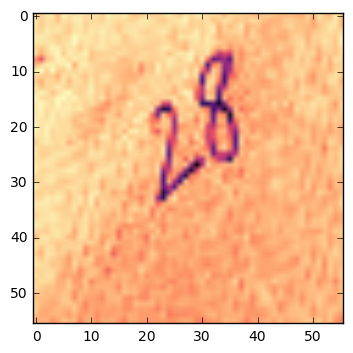

In [70]:
plt.imshow(a_image,cmap= 'magma')

In [71]:
b_image = ndimage.imread('743.jpg','L')

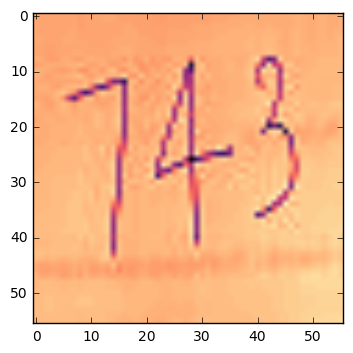

In [74]:
plt.imshow(b_image,cmap= 'magma')

In [77]:
images_testing = np.zeros(shape =(2,56,56,1))

In [79]:
images_testing[0] = a_image.reshape((56,56,1))
images_testing[1] = b_image.reshape((56,56,1))

In [80]:
images_testing

array([[[[ 134.81100464],
         [ 132.81100464],
         [ 136.81100464],
         ..., 
         [ 127.16999817],
         [ 138.16999817],
         [ 132.16999817]],

        [[ 137.81100464],
         [ 131.81100464],
         [ 135.81100464],
         ..., 
         [ 133.16999817],
         [ 138.16999817],
         [ 128.16999817]],

        [[ 136.81100464],
         [ 130.81100464],
         [ 136.81100464],
         ..., 
         [ 137.16999817],
         [ 136.16999817],
         [ 128.16999817]],

        ..., 
        [[ 132.81100464],
         [ 124.81099701],
         [ 123.81099701],
         ..., 
         [ 129.16999817],
         [ 129.16999817],
         [ 126.81099701]],

        [[ 128.81100464],
         [ 123.81099701],
         [ 124.81099701],
         ..., 
         [ 130.16999817],
         [ 125.16999817],
         [ 120.81099701]],

        [[ 125.81099701],
         [ 125.81099701],
         [ 125.81099701],
         ..., 
         [ 129.16999817],
  

In [82]:
train_images[0].shape

(56, 56, 1)

In [83]:
from PIL import Image

In [100]:
a_image = Image.open('743.jpg')

In [101]:
a_image = a_image.convert('1')

In [102]:
a_image.save('result.jpg')

In [103]:
b = np.asarray(a_image)

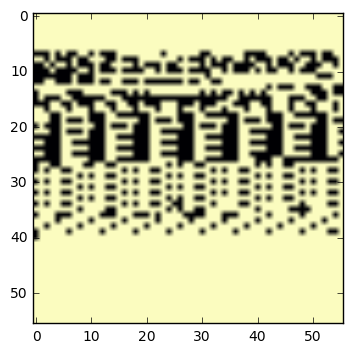

In [104]:
plt.imshow(np.ndarray.astype(b,float),cmap= 'magma')